# LLMantics dataset

**Import dataset**

In [1]:
import json

with open("ALL_preprocessed.json", 'r') as file:
    data = json.load(file)

In [ ]:
# CREATE a TOY dataset for making faster experiments

import json
import random

def read_json_file(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

def generate_random_dataset(original_data, num_samples=1000):
    random_dataset = []
    for _ in range(num_samples):
        random_sample = random.choice(original_data)
        random_dataset.append(random_sample)
    return random_dataset

def write_json_file(data, file_path):
    with open(file_path, 'w') as file:
        json.dump(data, file, indent=4)

# Path to the JSON file containing the original dataset
original_file_path = 'ALL_preprocessed.json'

# Path to save the randomly generated dataset
random_file_path = 'ALL_preprocessed_TOY.json'

# Read the original dataset from the JSON file
original_data = read_json_file(original_file_path)

# Generate a new dataset with 1000 random samples
random_dataset = generate_random_dataset(original_data, num_samples=500)

# Write the randomly generated dataset to a new JSON file
write_json_file(random_dataset, random_file_path)

print("Random dataset with 1000 samples generated successfully and saved as 'ALL_preprocessed_TOY.json'.")

## Data statistics

**Analysis on the dataset**

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def plot_histogram(sent_lengths_list):
    sent_np = np.asarray(sent_lengths_list)
    print("LENGHT SENTENCES STATISTICS:")
    print(f"| mean: {sent_np.mean()}")
    print(f"| std: {sent_np.std()}")
    print(f"| min: {sent_np.min()}")
    print(f"| max: {sent_np.max()}")

    plt.figure(figsize=(8,8))
    _ = plt.hist(sent_np, bins='auto', color = "gold", ec="orange")
    plt.show()

Counter({0: 4603, 1: 1334, 2: 530, 3: 282, 4: 138, 5: 82, 7: 57, 8: 39, 6: 39, 10: 35, 9: 34, 15: 16, 18: 9, 12: 8, 11: 8, 14: 7, 16: 6, 13: 6, 17: 3, 19: 3, 35: 2, 25: 2, 20: 2, 33: 2, 38: 1, 44: 1, 24: 1, 23: 1, 22: 1, 28: 1})
LENGHT SENTENCES STATISTICS:
| mean: 0.9891079553288294
| std: 2.436003996997197
| min: 0
| max: 44


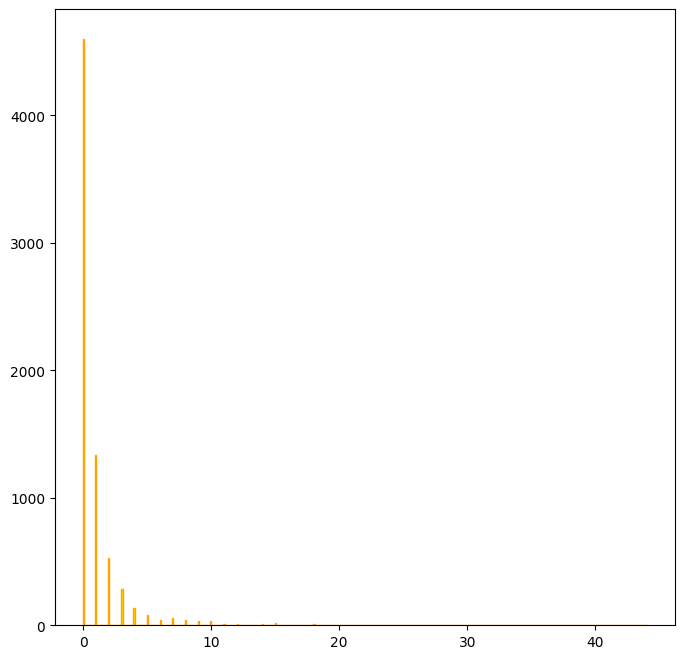

In [3]:
# gold candidate position in the candidate list
# as imagined, most of the gold candidates are the most frequent senses (position 0) 

from collections import Counter

l = []
for instance in data:
    gold_candidate = instance["gold"][0]
    l.append([i for i,c in enumerate(instance["candidates"]) if c==gold_candidate][0])

c = Counter(l)
print(c)

plot_histogram(l)

Counter({1: 1301, 2: 1056, 4: 867, 3: 790, 5: 648, 7: 460, 6: 459, 11: 294, 10: 271, 8: 200, 9: 182, 12: 116, 13: 99, 14: 77, 16: 50, 15: 36, 21: 35, 49: 31, 36: 31, 19: 31, 17: 27, 24: 27, 20: 25, 26: 18, 42: 16, 30: 16, 22: 15, 28: 11, 44: 11, 27: 10, 25: 10, 41: 6, 35: 5, 23: 5, 32: 5, 33: 5, 18: 5, 40: 1, 59: 1})
LENGHT SENTENCES STATISTICS:
| mean: 5.876464911071281
| std: 6.507738211787674
| min: 1
| max: 59


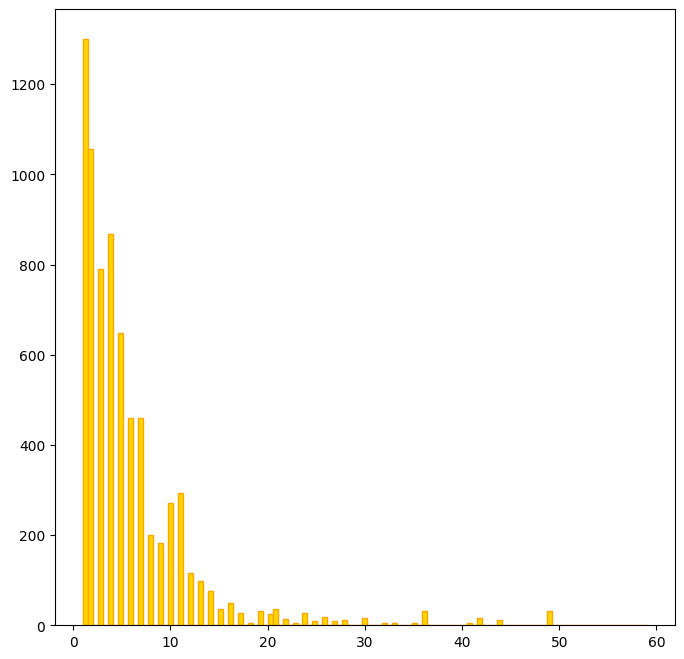

In [4]:
# ambiguity cardinality of target words
from collections import Counter

l = []
for instance in data:
    l.append(len(instance["candidates"]))

c = Counter(l)
print(c)

plot_histogram(l)

In [5]:
# pos tags histogram

# ambiguity cardinality of target words
from collections import Counter

l = []
for instance in data:
    l.append(instance["pos"])

c = Counter(l)
print(c)

Counter({'NOUN': 4300, 'VERB': 1652, 'ADJ': 955, 'ADV': 346})


In [6]:
# I want to see if the scores on the different pos tags are correlated to their average cardinality candidates
import torch

ris = {}
for pos in ["NOUN", "ADJ", "VERB", "ADV"]:
    l = list(filter(lambda x: x["pos"]==pos, data))
    length_cand_list = []
    for elem in l:
        length_cand_list.append(len(elem["candidates"]))
    ris[pos] = torch.tensor(length_cand_list, dtype=float).mean()
    
ris

{'NOUN': tensor(4.7823, dtype=torch.float64),
 'ADJ': tensor(4.0346, dtype=torch.float64),
 'VERB': tensor(10.3777, dtype=torch.float64),
 'ADV': tensor(3.0665, dtype=torch.float64)}

## One- and few-shot analysis in WSD setting

In [ ]:
# code to extrapolate the examples we want for the one/few-shot analysis
import random

l = []
for instance in data:
    candidates_dict = {c:i for i,c in enumerate(instance["candidates"])}
    if len(instance["candidates"])==16 and candidates_dict[instance["gold"][0]]!=0:
        l.append(instance)
print(len(l))
        
# one-shot
select_instance = l[random.randint(0, len(l) - 1)]
def2idx = {cand_def:i for i,cand_def in enumerate(select_instance["definitions"])}
word = select_instance["word"]
text = select_instance["text"].replace(" ,", ",").replace(" .", ".")
candidate_definitions = "\n".join([f"{idx}) {x}" for idx, x in enumerate(select_instance["definitions"])])
idx = def2idx[select_instance['gold_definitions'][0]]
gold_definition = f"""{idx}) {select_instance["gold_definitions"][0]}."""
ris = f"""Question: select the most suitable meaning for "{word}" in the following sentence: {text}\nChoose the corresponding definition among: \n{candidate_definitions}. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: {gold_definition}\n\n"""
print(repr(ris))

# few-shot
ris = ""
for i in range(3):
    select_instance = l[random.randint(0, len(l) - 1)]
    def2idx = {cand_def:i for i,cand_def in enumerate(select_instance["definitions"])}
    word = select_instance["word"]
    text = select_instance["text"].replace(" ,", ",").replace(" .", ".")
    candidate_definitions = "\n".join([f"{idx}) {x}" for idx, x in enumerate(select_instance["definitions"])])
    idx = def2idx[select_instance['gold_definitions'][0]]
    gold_definition = f"""{idx}) {select_instance["gold_definitions"][0]}."""
    
    ris += f"""Question: select the most suitable meaning for "{word}" in the following sentence: {text}\nChoose the corresponding definition among: \n{candidate_definitions}. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: {gold_definition}\n\n"""
print(repr(ris))


In [ ]:
# list of instance keys for the first phase of exps

ids_list = ["semeval2013.d007.s006.t005", 
"senseval2.d000.s017.t011", 
"senseval3.d000.s113.t002", 
"senseval2.d001.s085.t001", 
"semeval2007.d001.s011.t001", 
"senseval2.d000.s006.t008", 
"senseval2.d000.s013.t000", 
"senseval2.d000.s061.t012", 
"senseval2.d000.s017.t002", 
"senseval2.d000.s062.t006", 
"senseval2.d000.s011.t003", 
"senseval2.d000.s012.t005",

["semeval2013.d007.s006.t005", "semeval2013.d005.s029.t000", "semeval2013.d009.s021.t001"], 

["senseval2.d000.s017.t011", "senseval2.d002.s059.t001", "senseval3.d002.s034.t000"], 

["senseval3.d000.s113.t002", "senseval2.d000.s063.t007", "semeval2007.d000.s009.t002"], 

["senseval2.d001.s085.t001", "senseval2.d000.s005.t004", "senseval2.d002.s061.t012"], 

["semeval2007.d001.s011.t001", "semeval2013.d005.s013.t001", "semeval2013.d008.s009.t004"], 

["senseval2.d000.s006.t008", "senseval2.d000.s042.t002", "senseval3.d001.s042.t009"], 

["senseval2.d000.s013.t000", "semeval2007.d000.s031.t004", "semeval2015.d000.s014.t005"], 

["senseval2.d000.s061.t012", "senseval2.d001.s083.t003", "semeval2015.d001.s033.t004"], 

["senseval2.d000.s017.t002", "senseval2.d000.s061.t017", "senseval3.d001.s028.t004"], 

["senseval2.d000.s062.t006", "senseval2.d002.s003.t002", "senseval2.d002.s049.t007"], 

["senseval2.d000.s011.t003", "senseval2.d000.s052.t002", "senseval3.d000.s051.t001"], 

["senseval2.d000.s012.t005", "senseval2.d001.s041.t000", "semeval2015.d001.s046.t001"] ]

len(ids_list)

In [ ]:
# code to generate prompts for the one/few-shot analysis

for id_ in ids_list:
    if type(id_) is not list:
        for instance in data:
            if instance["id"] == id_:
                def2idx = {cand_def:i for i,cand_def in enumerate(instance["definitions"])}
                word = instance["word"]
                text = instance["text"].replace(" ,", ",").replace(" .", ".")
                candidate_definitions = "\n".join([f"{idx}) {x}" for idx, x in enumerate(instance["definitions"])])
                idx = def2idx[instance['gold_definitions'][0]]
                gold_definition = f"""{idx}) {instance["gold_definitions"][0]}."""
                
                ris = f"""Question: select the most suitable meaning for "{word}" in the following sentence: {text}\nChoose the corresponding definition among: \n{candidate_definitions}. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: {gold_definition}\n\n"""
                print(repr(ris))
    else:
        ris = ""
        for id__ in id_:
            for instance in data:
                if instance["id"] == id__:
                    def2idx = {cand_def:i for i,cand_def in enumerate(instance["definitions"])}
                    word = instance["word"]
                    text = instance["text"].replace(" ,", ",").replace(" .", ".")
                    candidate_definitions = "\n".join([f"{idx}) {x}" for idx, x in enumerate(instance["definitions"])])
                    idx = def2idx[instance['gold_definitions'][0]]
                    gold_definition = f"""{idx}) {instance["gold_definitions"][0]}."""
                    
                    ris += f"""Question: select the most suitable meaning for "{word}" in the following sentence: {text}\nChoose the corresponding definition among: \n{candidate_definitions}. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: {gold_definition}\n\n"""
        print(repr(ris))


## Creating the dataset for finetuning WiC

In [4]:
import json
from tqdm import tqdm

data_path = "training.en-en.data"
gold_path = "training.en-en.gold"
with open(data_path, "r") as fr:
    data = json.load(fr)
with open(gold_path, "r") as fr:
    gold = json.load(fr)

json_data = []
with open(f"training.json", "w") as fw_json:
    for instance_data, instance_gold in tqdm(zip(data, gold), total=len(gold)):
        answer = "False" if  instance_gold["tag"]=="F" else "True"
        sentence1, sentence2 = instance_data["sentence1"], instance_data["sentence2"]
        target_word1, target_word2 = sentence1[int(instance_data["start1"]):int(instance_data["end1"])], sentence2[int(instance_data["start2"]):int(instance_data["end2"])]
        
        prompt = """Question: determine whether the target words, {target_word1} and {target_word2}, refer to the same meaning in the following sentences. First sentence: {sentence1} Second sentence: {sentence2} If the meaning expressed by the two target words is the same, answer with True. Instead, if the meaning is not the same, answer with False. Do not motivate your answer. Answer: {answer}.""".format(
                target_word1=target_word1,
                target_word2=target_word2,
                sentence1=sentence1,
                sentence2=sentence2,
                answer=answer)
        json_elem = {"prompt":prompt}
        json_data.append(json_elem)
    json.dump(json_data, fw_json, indent=4)
            

100%|██████████| 8000/8000 [00:00<00:00, 409770.07it/s]


**New sentence embedder... it's actually a LLM. Is it better?**

For the moment the problem is the memory it employs...

In [1]:

from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer("Salesforce/SFR-Embedding-Mistral")

def get_detailed_instruct(task_description: str, query: str) -> str:
    return f'Instruct: {task_description}\nQuery: {query}'

# each query must come with a one-sentence instruction that describes the task
#task = 'Given a web search query, retrieve relevant passages that answer the query'
task = "Given a sense definition query, retrieve the most similar sense to that query"

#senseval3.d001.s034.t002
generated_answer = "To discover or ascertain by research or study.Solution: In the given sentence, \"find\" means"
queries = [ f"Instruct: {task}\nQuery: {generated_answer}"]

candidate_definitions = [
        "come upon, as if by accident; meet with",
        "discover or determine the existence, presence, or fact of",
        "come upon after searching; find the location of something that was missed or lost",
        "establish after a calculation, investigation, experiment, survey, or study",
        "come to believe on the basis of emotion, intuitions, or indefinite grounds",
        "perceive or be contemporaneous with",
        "get something or somebody for a specific purpose",
        "make a discovery, make a new finding",
        "make a discovery",
        "obtain through effort or management",
        "decide on and make a declaration about",
        "receive a specified treatment (abstract)",
        "perceive oneself to be in a certain condition or place",
        "get or find back; recover the use of",
        "succeed in reaching; arrive at",
        "accept and make use of one's personality, abilities, and situation"
]

gold_definition = "establish after a calculation, investigation, experiment, survey, or study"


embeddings = model.encode(queries + candidate_definitions)
scores = util.cos_sim(embeddings[:2], embeddings[2:]) * 100
print(scores.tolist())
# [[86.71537780761719, 36.645721435546875], [35.00497055053711, 82.07388305664062]]


/home/lavallone/miniconda3/envs/sappia/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/home/lavallone/miniconda3/envs/sappia/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


model.safetensors.index.json:   0%|          | 0.00/22.2k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Error while downloading from https://cdn-lfs-us-1.huggingface.co/repos/32/65/3265610a542e455de4a8ae6370833d2f81c7533be4e7e971b6dc9fb56d6ef1ef/841e0ce0c37d7e05c7cdce5ab9b614ee2b38a5f4f860c245e614970aff627d40?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27model-00002-of-00003.safetensors%3B+filename%3D%22model-00002-of-00003.safetensors%22%3B&Expires=1720358954&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyMDM1ODk1NH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzMyLzY1LzMyNjU2MTBhNTQyZTQ1NWRlNGE4YWU2MzcwODMzZDJmODFjNzUzM2JlNGU3ZTk3MWI2ZGM5ZmI1NmQ2ZWYxZWYvODQxZTBjZTBjMzdkN2UwNWM3Y2RjZTVhYjliNjE0ZWUyYjM4YTVmNGY4NjBjMjQ1ZTYxNDk3MGFmZjYyN2Q0MD9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPSoifV19&Signature=nvXziMhdxbmRaadMdRF-z6Q0Nstxw%7EMm20JSzNq6ddOZViul%7EiEhiVsfleHob68CAaoEc2MwhrWmrhrkrIIEMb%7EWPEKuiZOhIi-5l-91z%7ERX8Ndv9MLJFGwKWJDyMoYnkyKQwUvXZ4leALoQtAN4uLBQojqQuaWT7ySspSaEwOT5LW70vQbqf86Ap-ph8cifYsMzI6VxI

model-00002-of-00003.safetensors:   1%|          | 31.5M/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.28G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/981 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 224.00 MiB (GPU 0; 5.80 GiB total capacity; 5.52 GiB already allocated; 143.56 MiB free; 5.52 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [3]:
!pip install --upgrade transformers tokenizers




In [4]:
!pip show transformers tokenizers

Name: transformers
Version: 4.42.3
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /home/lavallone/miniconda3/envs/sappia/lib/python3.10/site-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: booknlp, peft, sentence-transformers
---
Name: tokenizers
Version: 0.19.1
Summary: 
Home-page: 
Author: Anthony MOI <m.anthony.moi@gmail.com>
Author-email: Nicolas Patry <patry.nicolas@protonmail.com>, Anthony Moi <anthony@huggingface.co>
License: 
Location: /home/lavallone/miniconda3/envs/sappia/lib/python3.10/site-packages
Requires: huggingface-hub
Required-by: transformers


In [85]:
s = """Question: select the most suitable meaning for "down" in the following sentence: Shuts the program down.\nChoose the corresponding definition among: \n0) spatially or metaphorically from a higher to a lower level or position\n1) away from a more central or a more northerly place\n2) paid in cash at time of purchase\n3) from an earlier time\n4) to a lower intensity\n5) in an inactive or inoperative state. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: 5) in an inactive or inoperative state.\n\nQuestion: select the most suitable meaning for "table" in the following sentence: I felt the temblor begin and glanced at the table next to mine, smiled that guilty smile and we both mouthed the words, `` Earth-quake ! `` together.\nChoose the corresponding definition among: \n0) a set of data arranged in rows and columns\n1) a piece of furniture having a smooth flat top that is usually supported by one or more vertical legs\n2) a piece of furniture with tableware for a meal laid out on it\n3) flat tableland with steep edges\n4) a company of people assembled at a table for a meal or game\n5) food or meals in general. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: 4) a company of people assembled at a table for a meal or game.\n\nQuestion: select the most suitable meaning for "realize" in the following sentence: If we want to understand how it works, the best thing we can do is to realize that our input is being converted into MathML although it is not necessary to know MathML.\nChoose the corresponding definition among: \n0) be fully aware or cognizant of\n1) perceive (an idea or situation) mentally\n2) make real or concrete; give reality or substance to\n3) earn on some commercial or business transaction; earn as salary or wages\n4) convert into cash; of goods and property\n5) expand or complete (a part in a piece of baroque music) by supplying the harmonies indicated in the figured bass. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: 1) perceive (an idea or situation) mentally.\n\nQuestion: select the most suitable meaning for '{word}' in the following sentence: {text}\nChoose the corresponding definition among: \n{candidate_definitions}.\nAnswer by reporting the corresponding definition and do not motivate your answer. \nAnswer: """
print(s)

Question: select the most suitable meaning for "down" in the following sentence: Shuts the program down.
Choose the corresponding definition among: 
0) spatially or metaphorically from a higher to a lower level or position
1) away from a more central or a more northerly place
2) paid in cash at time of purchase
3) from an earlier time
4) to a lower intensity
5) in an inactive or inoperative state. 
Answer by reporting the corresponding definition and do not motivate your answer. Answer: 5) in an inactive or inoperative state.

Question: select the most suitable meaning for "table" in the following sentence: I felt the temblor begin and glanced at the table next to mine, smiled that guilty smile and we both mouthed the words, `` Earth-quake ! `` together.
Choose the corresponding definition among: 
0) a set of data arranged in rows and columns
1) a piece of furniture having a smooth flat top that is usually supported by one or more vertical legs
2) a piece of furniture with tableware fo

In [86]:
import re

def increment_numbers_before_parenthesis(text):
    def increment_match(match):
        number = int(match.group(1))
        return f"{number + 1})"
    
    # Regex pattern to find numbers followed by a closing parenthesis
    pattern = re.compile(r'(\d+)\)')
    
    # Substitute each match using the increment_match function
    updated_text = pattern.sub(increment_match, text)
    
    return updated_text

s = increment_numbers_before_parenthesis(s)
print(s)

Question: select the most suitable meaning for "down" in the following sentence: Shuts the program down.
Choose the corresponding definition among: 
1) spatially or metaphorically from a higher to a lower level or position
2) away from a more central or a more northerly place
3) paid in cash at time of purchase
4) from an earlier time
5) to a lower intensity
6) in an inactive or inoperative state. 
Answer by reporting the corresponding definition and do not motivate your answer. Answer: 6) in an inactive or inoperative state.

Question: select the most suitable meaning for "table" in the following sentence: I felt the temblor begin and glanced at the table next to mine, smiled that guilty smile and we both mouthed the words, `` Earth-quake ! `` together.
Choose the corresponding definition among: 
1) a set of data arranged in rows and columns
2) a piece of furniture having a smooth flat top that is usually supported by one or more vertical legs
3) a piece of furniture with tableware fo

In [89]:
r"""Question: select the most suitable meaning for "realize" in the following sentence: If we want to understand how it works, the best thing we can do is to realize that our input is being converted into MathML although it is not necessary to know MathML.
Choose the corresponding definition among: 
1) be fully aware or cognizant of
2) perceive (an idea or situation) mentally
3) make real or concrete; give reality or substance to
4) earn on some commercial or business transaction; earn as salary or wages
5) convert into cash; of goods and property
6) expand or complete (a part in a piece of baroque music) by supplying the harmonies indicated in the figured bass. 
Answer by reporting the corresponding definition and do not motivate your answer. Answer:"""

'Question: select the most suitable meaning for "realize" in the following sentence: If we want to understand how it works, the best thing we can do is to realize that our input is being converted into MathML although it is not necessary to know MathML.\nChoose the corresponding definition among: \n1) be fully aware or cognizant of\n2) perceive (an idea or situation) mentally\n3) make real or concrete; give reality or substance to\n4) earn on some commercial or business transaction; earn as salary or wages\n5) convert into cash; of goods and property\n6) expand or complete (a part in a piece of baroque music) by supplying the harmonies indicated in the figured bass. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer:'

In [91]:
prompts = {"ambiguity_analysis":{
                                "1_candidate":{
                                        "mfs":{
                                                "one_shot":"""Question: select the most suitable meaning for "matters" in the following sentence: Since local benefit-seeking matters more and national policy making matters less in the lower chamber of Congress, this is precisely the pattern one would expect if Republicans are less willing to engage in local benefit-seeking than their Democratic counterparts.\nChoose the corresponding definition among: \n0) have weight; have import, carry weight. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: 0) have weight; have import, carry weight.\n\nQuestion: select the most suitable meaning for '{word}' in the following sentence: {text}\nChoose the corresponding definition among: \n{candidate_definitions}.\nAnswer by reporting the corresponding definition and do not motivate your answer. \nAnswer: """,
                                                "few_shot":"""Question: select the most suitable meaning for "beheld" in the following sentence: He looked up with bloodshot eyes and beheld the stranger sitting across the table, smiling a secret smile at him, as if they were fellow conspirators.\nChoose the corresponding definition among: \n0) see with attention. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: 0) see with attention.\n\nQuestion: select the most suitable meaning for "somebody" in the following sentence: I \'ll do anything for somebody I like.\nChoose the corresponding definition among: \n0) a human being. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: 0) a human being.\n\nQuestion: select the most suitable meaning for "Summary" in the following sentence: For more information, see the Summary of Product Characteristics ( also part of the EPAR ).\nChoose the corresponding definition among: \n0) a brief statement that presents the main points in a concise form. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: 0) a brief statement that presents the main points in a concise form.\n\nQuestion: select the most suitable meaning for '{word}' in the following sentence: {text}\nChoose the corresponding definition among: \n{candidate_definitions}.\nAnswer by reporting the corresponding definition and do not motivate your answer. \nAnswer: """,
                                                },
                                        },
                                "3_candidates":{
                                        "mfs":{
                                                "one_shot":"""Question: select the most suitable meaning for "based" in the following sentence: kalgebra is a MathML based graph calculator.\nChoose the corresponding definition among: \n0) use as a basis for; found on\n1) situate as a center of operations\n2) use (purified cocaine) by burning it and inhaling the fumes. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: 0) use as a basis for; found on.\n\nQuestion: select the most suitable meaning for '{word}' in the following sentence: {text}\nChoose the corresponding definition among: \n{candidate_definitions}.\nAnswer by reporting the corresponding definition and do not motivate your answer. \nAnswer: """,
                                                "few_shot":"""Question: select the most suitable meaning for "often" in the following sentence: He believed colon cancer might also arise from multiple `` hits `` on cancer suppressor genes, because it often seems to develop in stages.\nChoose the corresponding definition among: \n0) many times at short intervals\n1) frequently or in great quantities\n2) in many cases or instances. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: 0) many times at short intervals.\n\nQuestion: select the most suitable meaning for "available" in the following sentence: Cerenia contains the active substance maropitant and is available as tablet or as solution for injection.\nChoose the corresponding definition among: \n0) obtainable or accessible and ready for use or service\n1) not busy; not otherwise committed\n2) convenient for use or disposal. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: 0) obtainable or accessible and ready for use or service.\n\nQuestion: select the most suitable meaning for "based" in the following sentence: The study is based on 195 personal interviews with senior officials of the social partners as representatives of national level peak organisations in fifteen European countries.\nChoose the corresponding definition among: \n0) use as a basis for; found on\n1) situate as a center of operations\n2) use (purified cocaine) by burning it and inhaling the fumes. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: 0) use as a basis for; found on.\n\nQuestion: select the most suitable meaning for '{word}' in the following sentence: {text}\nChoose the corresponding definition among: \n{candidate_definitions}.\nAnswer by reporting the corresponding definition and do not motivate your answer. \nAnswer: """,
                                                },
                                        "not_mfs":{
                                                "one_shot":"""Question: select the most suitable meaning for "will" in the following sentence: Tricks such as those of Alonso and Ramos before the Ajax demonstrate wittiness but not the will to get remove of a sanction.\nChoose the corresponding definition among: \n0) the capability of conscious choice and decision and intention; - George Meredith\n1) a fixed and persistent intent or purpose\n2) a legal document declaring a person\'s wishes regarding the disposal of their property when they die. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: 1) a fixed and persistent intent or purpose.\n\nQuestion: select the most suitable meaning for '{word}' in the following sentence: {text}\nChoose the corresponding definition among: \n{candidate_definitions}.\nAnswer by reporting the corresponding definition and do not motivate your answer. \nAnswer: """,
                                                "few_shot":"""Question: select the most suitable meaning for "exit" in the following sentence: Maybe it would be better to humor the guy and then make an exit.\nChoose the corresponding definition among: \n0) an opening that permits escape or release\n1) euphemistic expressions for death\n2) the act of going out. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: 2) the act of going out.\n\nQuestion: select the most suitable meaning for "romantic" in the following sentence: It is not surprising that parents find this romantic extravagance so attractive.\nChoose the corresponding definition among: \n0) belonging to or characteristic of Romanticism or the Romantic Movement in the arts\n1) expressive of or exciting sexual love or romance\n2) not sensible about practical matters; idealistic and unrealistic. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: 2) not sensible about practical matters; idealistic and unrealistic.\n\nQuestion: select the most suitable meaning for "past" in the following sentence: Alimta is used in combination with cisplatin in patients who have not been treated before, and on its own in patients who have received another type of chemotherapy in the past.\nChoose the corresponding definition among: \n0) the time that has elapsed\n1) a earlier period in someone\'s life (especially one that they have reason to keep secret)\n2) a verb tense that expresses actions or states in the past. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: 1) a earlier period in someone\'s life (especially one that they have reason to keep secret).\n\nQuestion: select the most suitable meaning for '{word}' in the following sentence: {text}\nChoose the corresponding definition among: \n{candidate_definitions}.\nAnswer by reporting the corresponding definition and do not motivate your answer. \nAnswer: """,
                                                },
                                        },
                                "6_candidates":{
                                        "mfs":{
                                                "one_shot":"""Question: select the most suitable meaning for "social" in the following sentence: The Foundation organised, together with the European Commission, the Spanish Ministry of Social Affairs and the Galician regional government, a European conference on social exclusion : a major challenge for public welfare services.\nChoose the corresponding definition among: \n0) relating to human society and its members\n1) living together or enjoying life in communities or organized groups\n2) relating to or belonging to or characteristic of high society\n3) composed of sociable people or formed for the purpose of sociability\n4) tending to move or live together in groups or colonies of the same kind\n5) marked by friendly companionship with others. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: 0) relating to human society and its members.\n\nQuestion: select the most suitable meaning for '{word}' in the following sentence: {text}\nChoose the corresponding definition among: \n{candidate_definitions}.\nAnswer by reporting the corresponding definition and do not motivate your answer. \nAnswer: """,
                                                "few_shot":"""Question: select the most suitable meaning for "opinion" in the following sentence: The result is a generation of young people whose ignorance and intellectual incompetence is matched only by their good opinion of themselves.\nChoose the corresponding definition among: \n0) a personal belief or judgment that is not founded on proof or certainty\n1) a message expressing a belief about something; the expression of a belief that is held with confidence but not substantiated by positive knowledge or proof\n2) a belief or sentiment shared by most people; the voice of the people\n3) the legal document stating the reasons for a judicial decision\n4) the reason for a court\'s judgment (as opposed to the decision itself)\n5) a vague idea in which some confidence is placed. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: 0) a personal belief or judgment that is not founded on proof or certainty.\n\nQuestion: select the most suitable meaning for "social" in the following sentence: Over 100 participants from the main interest groups attended and debated issues such as the role of key actors including public authorities, social partners, voluntary and community organisations as well as service users.\nChoose the corresponding definition among: \n0) relating to human society and its members\n1) living together or enjoying life in communities or organized groups\n2) relating to or belonging to or characteristic of high society\n3) composed of sociable people or formed for the purpose of sociability\n4) tending to move or live together in groups or colonies of the same kind\n5) marked by friendly companionship with others. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: 0) relating to human society and its members.\n\nQuestion: select the most suitable meaning for "contains" in the following sentence: Case Studies Each national report contains a portfolio of between 25 and 30 initiatives which best present policies and practices to improve the recruitment, training and development of ageing workers in both the work place and the community.\nChoose the corresponding definition among: \n0) include or contain; have as a component\n1) contain or hold; have within\n2) lessen the intensity of; temper; hold in restraint; hold or keep within limits\n3) be divisible by\n4) be capable of holding or containing\n5) hold back, as of a danger or an enemy; check the expansion or influence of. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: 0) include or contain; have as a component.\n\nQuestion: select the most suitable meaning for '{word}' in the following sentence: {text}\nChoose the corresponding definition among: \n{candidate_definitions}.\nAnswer by reporting the corresponding definition and do not motivate your answer. \nAnswer: """,
                                                },
                                        "not_mfs":{
                                                "one_shot":"""Question: select the most suitable meaning for "questions" in the following sentence: For decades, appeals courts have recognized that coverage of notorious cases can raise questions about a trial \'s fairness.\nChoose the corresponding definition among: \n0) an instance of questioning\n1) the subject matter at issue\n2) a sentence of inquiry that asks for a reply\n3) uncertainty about the truth or factuality or existence of something\n4) a formal proposal for action made to a deliberative assembly for discussion and vote\n5) an informal reference to a marriage proposal. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: 1) the subject matter at issue.\n\nQuestion: select the most suitable meaning for '{word}' in the following sentence: {text}\nChoose the corresponding definition among: \n{candidate_definitions}.\nAnswer by reporting the corresponding definition and do not motivate your answer. \nAnswer: """,
                                                "few_shot":"""Question: select the most suitable meaning for "reason" in the following sentence: The reason is simple : Education takes place in the classroom, where the influence of money is minimal.\nChoose the corresponding definition among: \n0) a rational motive for a belief or action\n1) an explanation of the cause of some phenomenon\n2) the capacity for rational thought or inference or discrimination\n3) the state of having good sense and sound judgment\n4) a justification for something existing or happening\n5) a fact that logically justifies some premise or conclusion. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: 1) an explanation of the cause of some phenomenon.\n\nQuestion: select the most suitable meaning for "tossed" in the following sentence: This time, it just got stronger and then the building started shaking violently up and down as though it were a child \'s toy block that was being tossed.\nChoose the corresponding definition among: \n0) throw or toss with a light motion\n1) lightly throw to see which side comes up\n2) throw carelessly\n3) move or stir about violently\n4) throw or cast away\n5) agitate. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: 3) move or stir about violently.\n\nQuestion: select the most suitable meaning for "test" in the following sentence: This test was the first to predict reliably whether an individual could expect to develop cancer.\nChoose the corresponding definition among: \n0) trying something to find out about it\n1) any standardized procedure for measuring sensitivity or memory or intelligence or aptitude or personality etc\n2) a set of questions or exercises evaluating skill or knowledge\n3) the act of undergoing testing\n4) the act of testing something\n5) a hard outer covering as of some amoebas and sea urchins. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: 4) the act of testing something.\n\nQuestion: select the most suitable meaning for '{word}' in the following sentence: {text}\nChoose the corresponding definition among: \n{candidate_definitions}.\nAnswer by reporting the corresponding definition and do not motivate your answer. \nAnswer: """,
                                                },
                                        },
                                "10_candidates":{
                                        "mfs":{
                                                "one_shot":"""Question: select the most suitable meaning for "time" in the following sentence: Every time you enter an expression, the " ans " variable value will be changed to the last result.\nChoose the corresponding definition among: \n0) an instance or single occasion for some event\n1) a period of time considered as a resource under your control and sufficient to accomplish something\n2) an indefinite period (usually marked by specific attributes or activities)\n3) a suitable moment\n4) the continuum of experience in which events pass from the future through the present to the past\n5) a person\'s experience on a particular occasion\n6) a reading of a point in time as given by a clock\n7) the fourth coordinate that is required (along with three spatial dimensions) to specify a physical event\n8) rhythm as given by division into parts of equal duration\n9) the period of time a prisoner is imprisoned. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: 0) an instance or single occasion for some event.\n\nQuestion: select the most suitable meaning for '{word}' in the following sentence: {text}\nChoose the corresponding definition among: \n{candidate_definitions}.\nAnswer by reporting the corresponding definition and do not motivate your answer. \nAnswer: """,
                                                "few_shot":"""Question: select the most suitable meaning for "rise" in the following sentence: The indices have, however, been slowed by a renewed rise of the dollar, to a new two-month high against the Euro, which `` puts downward pressure on the sectors that are sensitive to the economic situation \'\', explained Owen Fitzpatrick from Deutsche Bank.\nChoose the corresponding definition among: \n0) a growth in strength or number or importance\n1) the act of changing location in an upward direction\n2) an upward slope or grade (as in a road)\n3) a movement upward\n4) the amount a salary is increased\n5) the property possessed by a slope or surface that rises\n6) a wave that lifts the surface of the water or ground\n7) (theology) the origination of the Holy Spirit at Pentecost\n8) an increase in cost\n9) increase in price or value. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: 0) a growth in strength or number or importance.\n\nQuestion: select the most suitable meaning for "seconds" in the following sentence: I just felt another aftershock a few seconds ago.\nChoose the corresponding definition among: \n0) 1/60 of a minute; the basic unit of time adopted under the Systeme International d\'Unites\n1) an indefinitely short time\n2) the fielding position of the player on a baseball team who is stationed near the second of the bases in the infield\n3) a particular point in time\n4) following the first in an ordering or series\n5) a 60th part of a minute of arc\n6) the official attendant of a contestant in a duel or boxing match\n7) a speech seconding a motion\n8) the gear that has the second lowest forward gear ratio in the gear box of a motor vehicle\n9) merchandise that has imperfections; usually sold at a reduced price without the brand name. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: 0) 1/60 of a minute; the basic unit of time adopted under the Systeme International d\'Unites.\n\nQuestion: select the most suitable meaning for "bells" in the following sentence: In the tower, five men and women pull rhythmically on ropes attached to the same five bells that first sounded here in 1614.\nChoose the corresponding definition among: \n0) a hollow device made of metal that makes a ringing sound when struck\n1) a push button at an outer door that gives a ringing or buzzing signal when pushed\n2) the sound of a bell being struck\n3) (nautical) each of the eight half-hour units of nautical time signaled by strokes of a ship\'s bell; eight bells signals 4:00, 8:00, or 12:00 o\'clock, either a.m. or p.m.\n4) the shape of a bell\n5) a phonetician and father of Alexander Graham Bell (1819-1905)\n6) English painter; sister of Virginia Woolf; prominent member of the Bloomsbury Group (1879-1961)\n7) United States inventor (born in Scotland) of the telephone (1847-1922)\n8) a percussion instrument consisting of a set of tuned bells that are struck with a hammer; used as an orchestral instrument\n9) the flared opening of a tubular device. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: 0) a hollow device made of metal that makes a ringing sound when struck.\n\nQuestion: select the most suitable meaning for '{word}' in the following sentence: {text}\nChoose the corresponding definition among: \n{candidate_definitions}.\nAnswer by reporting the corresponding definition and do not motivate your answer. \nAnswer: """,
                                                },
                                        "not_mfs":{
                                                "one_shot":"""Question: select the most suitable meaning for "time" in the following sentence: In patients who had not received chemotherapy in the past, the average survival time was 10.3 months in both groups.\nChoose the corresponding definition among: \n0) an instance or single occasion for some event\n1) a period of time considered as a resource under your control and sufficient to accomplish something\n2) an indefinite period (usually marked by specific attributes or activities)\n3) a suitable moment\n4) the continuum of experience in which events pass from the future through the present to the past\n5) a person\'s experience on a particular occasion\n6) a reading of a point in time as given by a clock\n7) the fourth coordinate that is required (along with three spatial dimensions) to specify a physical event\n8) rhythm as given by division into parts of equal duration\n9) the period of time a prisoner is imprisoned. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: 2) an indefinite period (usually marked by specific attributes or activities).\n\nQuestion: select the most suitable meaning for '{word}' in the following sentence: {text}\nChoose the corresponding definition among: \n{candidate_definitions}.\nAnswer by reporting the corresponding definition and do not motivate your answer. \nAnswer: """,
                                                "few_shot":"""Question: select the most suitable meaning for "looking" in the following sentence: For months the Johns Hopkins researchers, using gene probes, experimentally crawled down the length of chromosome 17, looking for the smallest common bit of genetic material lost in all tumor cells.\nChoose the corresponding definition among: \n0) perceive with attention; direct one\'s gaze towards\n1) give a certain impression or have a certain outward aspect\n2) have a certain outward or facial expression\n3) search or seek\n4) be oriented in a certain direction, often with respect to another reference point; be opposite to\n5) take charge of or deal with\n6) convey by one\'s expression\n7) look forward to the probable occurrence of\n8) accord in appearance with\n9) have faith or confidence in. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: 3) search or seek.\n\nQuestion: select the most suitable meaning for "translate" in the following sentence: To the extent that Democratic legislators from the South have held a disproportionate share of power in Congress since 1932 and have been able to translate such clout into relatively more local benefits for their respective constituencies, voters in the South have had an especially strong incentive to keep such Democrats in office.\nChoose the corresponding definition among: \n0) restate (words) from one language into another language\n1) change from one form or medium into another\n2) make sense of a language\n3) bring to a certain spiritual state\n4) change the position of (figures or bodies) in space without rotation\n5) be equivalent in effect\n6) be translatable, or be translatable in a certain way\n7) subject to movement in which every part of the body moves parallel to and the same distance as every other point on the body\n8) express, as in simple and less technical language\n9) determine the amino-acid sequence of a protein during its synthesis by using information on the messenger RNA. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: 5) be equivalent in effect.\n\nQuestion: select the most suitable meaning for "so" in the following sentence: A series of 5,000 or so changes is a `` peal `` and takes about three hours.\nChoose the corresponding definition among: \n0) to a very great extent or degree\n1) in a manner that facilitates\n2) in such a condition or manner, especially as expressed or implied\n3) to a certain unspecified extent or degree\n4) in the same way; also\n5) in the way indicated; ; ; (`thusly\' is a nonstandard variant)\n6) (usually followed by `that\') to an extent or degree as expressed\n7) subsequently or soon afterward (often used as sentence connectors)\n8) (used to introduce a logical conclusion) from that fact or reason or as a result\n9) in truth (often tends to intensify). \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: 3) to a certain unspecified extent or degree.\n\nQuestion: select the most suitable meaning for '{word}' in the following sentence: {text}\nChoose the corresponding definition among: \n{candidate_definitions}.\nAnswer by reporting the corresponding definition and do not motivate your answer. \nAnswer: """,
                                                },
                                        },
                                "16_candidates":{
                                        "mfs":{
                                                "one_shot":"""Question: select the most suitable meaning for "placed" in the following sentence: Because these freshmen placed far more emphasis on their partisan role -- spreading the Reagan revolution -- in national policy making, they were more vulnerable to defeat.\nChoose the corresponding definition among: \n0) put into a certain place or abstract location\n1) place somebody in a particular situation or location\n2) assign a rank or rating to\n3) assign a location to\n4) to arrange for\n5) take a place in a competition; often followed by an ordinal\n6) intend (something) to move towards a certain goal\n7) recognize as being; establish the identity of someone or something\n8) assign to (a job or a home)\n9) locate\n10) estimate\n11) identify the location or place of\n12) make an investment\n13) assign to a station\n14) finish second or better in a horse or dog race\n15) sing a note with the correct pitch. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: 0) put into a certain place or abstract location.\n\nQuestion: select the most suitable meaning for '{word}' in the following sentence: {text}\nChoose the corresponding definition among: \n{candidate_definitions}.\nAnswer by reporting the corresponding definition and do not motivate your answer. \nAnswer: """,
                                                "few_shot":"""Question: select the most suitable meaning for "worse" in the following sentence: -- In most states, increasing expenditures on education, in our current circumstances, will probably make things worse, not better.\nChoose the corresponding definition among: \n0) (comparative of `bad\') inferior to another in quality or condition or desirability\n1) changed for the worse in health or fitness\n2) having undesirable or negative qualities\n3) very intense\n4) feeling physical discomfort or pain (`tough\' is occasionally used colloquially for `bad\')\n5) (of foodstuffs) not in an edible or usable condition\n6) feeling or expressing regret or sorrow or a sense of loss over something done or undone\n7) not capable of being collected\n8) below average in quality or performance\n9) nonstandard\n10) not financially safe or secure\n11) physically unsound or diseased\n12) capable of harming\n13) characterized by wickedness or immorality\n14) reproduced fraudulently\n15) not working properly. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: 0) (comparative of `bad\') inferior to another in quality or condition or desirability.\n\nQuestion: select the most suitable meaning for "worse" in the following sentence: -- `` Community involvement `` is an even worse idea.\nChoose the corresponding definition among: \n0) (comparative of `bad\') inferior to another in quality or condition or desirability\n1) changed for the worse in health or fitness\n2) having undesirable or negative qualities\n3) very intense\n4) feeling physical discomfort or pain (`tough\' is occasionally used colloquially for `bad\')\n5) (of foodstuffs) not in an edible or usable condition\n6) feeling or expressing regret or sorrow or a sense of loss over something done or undone\n7) not capable of being collected\n8) below average in quality or performance\n9) nonstandard\n10) not financially safe or secure\n11) physically unsound or diseased\n12) capable of harming\n13) characterized by wickedness or immorality\n14) reproduced fraudulently\n15) not working properly. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: 0) (comparative of `bad\') inferior to another in quality or condition or desirability.\n\nQuestion: select the most suitable meaning for "returned" in the following sentence: Some time before midnight he returned to his apartment and hit the sack, putting the whole incident out of mind before he fell asleep.\nChoose the corresponding definition among: \n0) go or come back to place, condition, or activity where one has been before\n1) give back\n2) go back to a previous state\n3) go back to something earlier\n4) bring back to the point of departure\n5) return in kind\n6) make a return\n7) answer back\n8) be restored\n9) pay back\n10) pass down\n11) elect again\n12) be inherited by\n13) return to a previous position; in mathematics\n14) give or supply\n15) submit (a report, etc.) to someone in authority. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: 0) go or come back to place, condition, or activity where one has been before.\n\nQuestion: select the most suitable meaning for '{word}' in the following sentence: {text}\nChoose the corresponding definition among: \n{candidate_definitions}.\nAnswer by reporting the corresponding definition and do not motivate your answer. \nAnswer: """,
                                                },
                                        "not_mfs":{
                                                "one_shot":"""Question: select the most suitable meaning for "found" in the following sentence: Some found it on the screen of a personal computer.\nChoose the corresponding definition among: \n0) come upon, as if by accident; meet with\n1) discover or determine the existence, presence, or fact of\n2) come upon after searching; find the location of something that was missed or lost\n3) establish after a calculation, investigation, experiment, survey, or study\n4) come to believe on the basis of emotion, intuitions, or indefinite grounds\n5) perceive or be contemporaneous with\n6) get something or somebody for a specific purpose\n7) make a discovery, make a new finding\n8) make a discovery\n9) obtain through effort or management\n10) decide on and make a declaration about\n11) receive a specified treatment (abstract)\n12) perceive oneself to be in a certain condition or place\n13) get or find back; recover the use of\n14) succeed in reaching; arrive at\n15) accept and make use of one\'s personality, abilities, and situation. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: 2) come upon after searching; find the location of something that was missed or lost.\n\nQuestion: select the most suitable meaning for '{word}' in the following sentence: {text}\nChoose the corresponding definition among: \n{candidate_definitions}.\nAnswer by reporting the corresponding definition and do not motivate your answer. \nAnswer: """,
                                                "few_shot":"""Question: select the most suitable meaning for "places" in the following sentence: He \'d have to start going to some of the other places again.\nChoose the corresponding definition among: \n0) a point located with respect to surface features of some region\n1) any area set aside for a particular purpose\n2) an abstract mental location\n3) a general vicinity\n4) the post or function properly or customarily occupied or served by another\n5) a particular situation\n6) where you live at a particular time\n7) a job in an organization\n8) the particular portion of space occupied by something\n9) proper or designated social situation\n10) a space reserved for sitting (as in a theater or on a train or airplane)\n11) the passage that is being read\n12) proper or appropriate position or location\n13) a public square with room for pedestrians\n14) an item on a list or in a sequence\n15) a blank area. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: 1) any area set aside for a particular purpose.\n\nQuestion: select the most suitable meaning for "find" in the following sentence: First, economists James Bennett and Thomas DiLorenzo find that GOP senators turn back roughly 10 % more of their allocated personal staff budgets than Democrats do.\nChoose the corresponding definition among: \n0) come upon, as if by accident; meet with\n1) discover or determine the existence, presence, or fact of\n2) come upon after searching; find the location of something that was missed or lost\n3) establish after a calculation, investigation, experiment, survey, or study\n4) come to believe on the basis of emotion, intuitions, or indefinite grounds\n5) perceive or be contemporaneous with\n6) get something or somebody for a specific purpose\n7) make a discovery, make a new finding\n8) make a discovery\n9) obtain through effort or management\n10) decide on and make a declaration about\n11) receive a specified treatment (abstract)\n12) perceive oneself to be in a certain condition or place\n13) get or find back; recover the use of\n14) succeed in reaching; arrive at\n15) accept and make use of one\'s personality, abilities, and situation. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: 3) establish after a calculation, investigation, experiment, survey, or study.\n\nQuestion: select the most suitable meaning for "found" in the following sentence: Despite that, when the Johns Hopkins scientists compared the gene they had found in the human cancer cells with the Mr. Levine \'s p53 gene they found the two were identical ; it turned out that in Mr. Levine \'s cancer studies, he had unknowingly been observing a damaged form of p53 -- a cancer-suppressing gene.\nChoose the corresponding definition among: \n0) come upon, as if by accident; meet with\n1) discover or determine the existence, presence, or fact of\n2) come upon after searching; find the location of something that was missed or lost\n3) establish after a calculation, investigation, experiment, survey, or study\n4) come to believe on the basis of emotion, intuitions, or indefinite grounds\n5) perceive or be contemporaneous with\n6) get something or somebody for a specific purpose\n7) make a discovery, make a new finding\n8) make a discovery\n9) obtain through effort or management\n10) decide on and make a declaration about\n11) receive a specified treatment (abstract)\n12) perceive oneself to be in a certain condition or place\n13) get or find back; recover the use of\n14) succeed in reaching; arrive at\n15) accept and make use of one\'s personality, abilities, and situation. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: 7) make a discovery, make a new finding.\n\nQuestion: select the most suitable meaning for '{word}' in the following sentence: {text}\nChoose the corresponding definition among: \n{candidate_definitions}.\nAnswer by reporting the corresponding definition and do not motivate your answer. \nAnswer: """,
                                                },
                                        },
        },
        "mfs_analysis":{
                "6_candidates":{
                                "mfs":{
                                        "one_shot":"""Question: select the most suitable meaning for "president" in the following sentence: `` This stunning breach of ethics and indifference to the code belies claims by several justices that the court abides by the same rules that apply to all other federal judges, \'\' said Bob Edgar, the president of Common Cause.\nChoose the corresponding definition among: \n0) an executive officer of a firm or corporation\n1) the person who holds the office of head of state of the United States government\n2) the chief executive of a republic\n3) the officer who presides at the meetings of an organization\n4) the head administrative officer of a college or university\n5) the office of the United States head of state. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: 0) an executive officer of a firm or corporation.\n\nQuestion: select the most suitable meaning for '{word}' in the following sentence: {text}\nChoose the corresponding definition among: \n{candidate_definitions}.\nAnswer by reporting the corresponding definition and do not motivate your answer. \nAnswer: """,
                                        "few_shot":"""Question: select the most suitable meaning for "down" in the following sentence: For months the Johns Hopkins researchers, using gene probes, experimentally crawled down the length of chromosome 17, looking for the smallest common bit of genetic material lost in all tumor cells.\nChoose the corresponding definition among: \n0) spatially or metaphorically from a higher to a lower level or position\n1) away from a more central or a more northerly place\n2) paid in cash at time of purchase\n3) from an earlier time\n4) to a lower intensity\n5) in an inactive or inoperative state. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: 0) spatially or metaphorically from a higher to a lower level or position.\n\nQuestion: select the most suitable meaning for "table" in the following sentence: An examination of changes in personal staffing decisions in the Senate between 1986 and 1987 -LRB- when control of that body changed party hands -RRB-, moreover, reveals that the personal staffing differences noted in the table can not be attributed to the disproportionate control Democrats exercise, due to their majority-party status, over other resources such as committee staff.\nChoose the corresponding definition among: \n0) a set of data arranged in rows and columns\n1) a piece of furniture having a smooth flat top that is usually supported by one or more vertical legs\n2) a piece of furniture with tableware for a meal laid out on it\n3) flat tableland with steep edges\n4) a company of people assembled at a table for a meal or game\n5) food or meals in general. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: 0) a set of data arranged in rows and columns.\n\nQuestion: select the most suitable meaning for "realize" in the following sentence: To the extent that potential Republican candidates and their financial backers realize that the congressional prisoner \'s dilemma game works to their disadvantage, the Republican Party will be hindered in its attempts to field a competitive slate of congressional candidates.\nChoose the corresponding definition among: \n0) be fully aware or cognizant of\n1) perceive (an idea or situation) mentally\n2) make real or concrete; give reality or substance to\n3) earn on some commercial or business transaction; earn as salary or wages\n4) convert into cash; of goods and property\n5) expand or complete (a part in a piece of baroque music) by supplying the harmonies indicated in the figured bass. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: 0) be fully aware or cognizant of.\n\nQuestion: select the most suitable meaning for '{word}' in the following sentence: {text}\nChoose the corresponding definition among: \n{candidate_definitions}.\nAnswer by reporting the corresponding definition and do not motivate your answer. \nAnswer: """,
                                        },
                                "not_mfs":{
                                        "one_shot":"""Question: select the most suitable meaning for "president" in the following sentence: The Central Council of Church Bell Ringers, a sort of parliament of ringing groups, aims to improve relations with vicars, says John C. Baldwin, president.\nChoose the corresponding definition among: \n0) an executive officer of a firm or corporation\n1) the person who holds the office of head of state of the United States government\n2) the chief executive of a republic\n3) the officer who presides at the meetings of an organization\n4) the head administrative officer of a college or university\n5) the office of the United States head of state. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: 3) the officer who presides at the meetings of an organization.\n\nQuestion: select the most suitable meaning for '{word}' in the following sentence: {text}\nChoose the corresponding definition among: \n{candidate_definitions}.\nAnswer by reporting the corresponding definition and do not motivate your answer. \nAnswer: """,
                                        "few_shot":"""Question: select the most suitable meaning for "down" in the following sentence: Shuts the program down.\nChoose the corresponding definition among: \n0) spatially or metaphorically from a higher to a lower level or position\n1) away from a more central or a more northerly place\n2) paid in cash at time of purchase\n3) from an earlier time\n4) to a lower intensity\n5) in an inactive or inoperative state. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: 5) in an inactive or inoperative state.\n\nQuestion: select the most suitable meaning for "table" in the following sentence: I felt the temblor begin and glanced at the table next to mine, smiled that guilty smile and we both mouthed the words, `` Earth-quake ! `` together.\nChoose the corresponding definition among: \n0) a set of data arranged in rows and columns\n1) a piece of furniture having a smooth flat top that is usually supported by one or more vertical legs\n2) a piece of furniture with tableware for a meal laid out on it\n3) flat tableland with steep edges\n4) a company of people assembled at a table for a meal or game\n5) food or meals in general. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: 4) a company of people assembled at a table for a meal or game.\n\nQuestion: select the most suitable meaning for "realize" in the following sentence: If we want to understand how it works, the best thing we can do is to realize that our input is being converted into MathML although it is not necessary to know MathML.\nChoose the corresponding definition among: \n0) be fully aware or cognizant of\n1) perceive (an idea or situation) mentally\n2) make real or concrete; give reality or substance to\n3) earn on some commercial or business transaction; earn as salary or wages\n4) convert into cash; of goods and property\n5) expand or complete (a part in a piece of baroque music) by supplying the harmonies indicated in the figured bass. \nAnswer by reporting the corresponding definition and do not motivate your answer. Answer: 1) perceive (an idea or situation) mentally.\n\nQuestion: select the most suitable meaning for '{word}' in the following sentence: {text}\nChoose the corresponding definition among: \n{candidate_definitions}.\nAnswer by reporting the corresponding definition and do not motivate your answer. \nAnswer: """,
                                        },
                                },
        }
}


for k,v in prompts["ambiguity_analysis"].items():
    for kk,vv in v.items():
        for approach, string in vv.items():
            vv[approach] = increment_numbers_before_parenthesis(vv[approach])
prompts

import json

with open("porco.json", 'w') as json_file:
    json.dump(prompts, json_file, indent=4)